# Project Eden - Machine Learning Magic

## Import Dependencies

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import sklearn as sk
%matplotlib inline

In [2]:
file_path='model/production_clim_merged_georasters.csv'
data=pd.read_csv(file_path)

## Data Exploration

In [54]:
print(data.columns)
print(len(data.columns))

Index(['x', 'y', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', 'acof', 'bana',
       'barl', 'bean', 'cass', 'chic', 'cnut', 'coco', 'cott', 'cowp', 'grou',
       'lent', 'maiz', 'ocer', 'ofib', 'oilp', 'ooil', 'opul', 'orts', 'pige',
       'plnt', 'pmil', 'pota', 'rape', 'rcof', 'rest', 'rice', 'sesa', 'smil',
       'sorg', 'soyb', 'sugb', 'sugc', 'sunf', 'swpo', 'teas', 'temf', 'toba',
       'trof', 'vege', 'whea', 'yams'],
      dtype='object')
63


In [4]:
data.head()

,x,y,01,02,03,04,05,06,07,08,...,sugc,sunf,swpo,teas,temf,toba,trof,vege,whea,yams
0,-37.166667,83.666667,0.0,0.0,17.645822,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-37.083333,83.666667,0.0,0.0,19.059517,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-37.000000,83.666667,0.0,0.0,20.045350,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-36.916667,83.666667,0.0,0.0,19.985059,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-36.833333,83.666667,0.0,0.0,19.797453,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The first 2 columns are X, Y.

The subsequent 19 columns are the features.

The remaining 42 columns are the various crops.

In [15]:
print('Number of NaNs in the dataframe:\n',data.isnull().sum())

Number of NaNs in the dataframe:
 x             0
y             0
01            0
02            0
03         4556
04            0
05            0
06            0
07            0
08            0
09            0
10            0
11            0
12            0
13            0
14            0
15            0
16            0
17            0
18            0
19            0
acof    2422794
bana    2422794
barl    2422794
bean    2422794
cass    2422794
chic    2422794
cnut    2422794
coco    2422794
cott    2422794
         ...   
maiz    2422794
ocer    2422794
ofib    2422794
oilp    2422794
ooil    2422794
opul    2422794
orts    2422794
pige    2422794
plnt    2422794
pmil    2422794
pota    2422794
rape    2422794
rcof    2422794
rest    2422794
rice    2422794
sesa    2422794
smil    2422794
sorg    2422794
soyb    2422794
sugb    2422794
sugc    2422794
sunf    2422794
swpo    2422794
teas    2422794
temf    2422794
toba    2422794
trof    2422794
vege    2422794
whea    2422794
yams  

In [66]:
data_no_nan= data[data['bana'].notnull()]
data_nan = data[data['bana'].isnull()]
print (data_no_nan.head())
# This Cell is part of Data Manipulation and is essential for correct execution.

                x          y        01        02         03          04  \
166309  27.583333  71.166667  0.474861  3.859167  21.561590  568.764901   
166310  27.666667  71.166667  1.248333  3.903333  20.648446  531.442762   
168206  23.833333  71.083333  1.658333  3.166667  19.947351  485.091153   
168207  23.916667  71.083333  1.875409  4.060621  19.878740  497.253663   
168208  24.000000  71.083333  1.970569  4.249603  19.296813  500.055884   

               05        06         07        08  ...   sugc  sunf  swpo  \
166309  11.606667 -7.526667  19.133333  1.082778  ...    0.0   0.0   0.0   
166310  11.460000 -6.680000  18.140000  1.944444  ...    0.0   0.0   0.0   
168206  10.480000 -5.800000  16.280000 -0.146667  ...    0.0   0.0   0.0   
168207  11.288236 -6.741177  18.029412  0.015033  ...    0.0   0.0   0.0   
168208  11.341269 -6.687302  18.028571  0.054762  ...    0.0   0.0   0.0   

        teas  temf  toba  trof  vege  whea  yams  
166309   0.0   1.0   0.0   0.0   0.0   0.

In [24]:
print(data['acof'].isnull().sum())
print(len(data_nan.index))

2422794
2422794


(array([  83503.,  200315.,  254722.,  261847.,  164247.,  321389.,
        300275.,  334446.,  344678.,  157372.]), array([ -1.80000000e+02,  -1.44008333e+02,  -1.08016667e+02,
        -7.20250000e+01,  -3.60333333e+01,  -4.16666650e-02,
         3.59500000e+01,   7.19416667e+01,   1.07933333e+02,
         1.43925000e+02,   1.79916667e+02]), <a list of 10 Patch objects>)


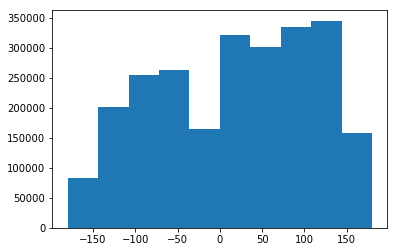

In [30]:
plt.hist(data[data['bana'].isnull()]['x'])

(array([    270.,   22453.,  102469.,   96888.,   34028.,  175221.,
         112625.,  105678.,   85860.,   11928.]),
 array([-179.16666667, -143.25833334, -107.35      ,  -71.44166667,
         -35.53333333,    0.375     ,   36.28333333,   72.19166667,
         108.1       ,  144.00833334,  179.91666667]),
 <a list of 10 Patch objects>)

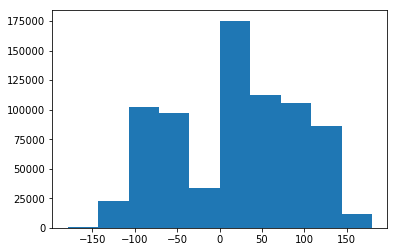

In [26]:
plt.hist(data[data['bana'].notnull()]['x'])

(array([ 762163.,  119209.,   21593.,  112944.,   88782.,   99508.,
         192347.,  222521.,  468782.,  334945.]),
 array([-89.91666667, -72.55833334, -55.2       , -37.84166667,
        -20.48333333,  -3.125     ,  14.23333333,  31.59166667,
         48.95      ,  66.30833334,  83.66666667]),
 <a list of 10 Patch objects>)

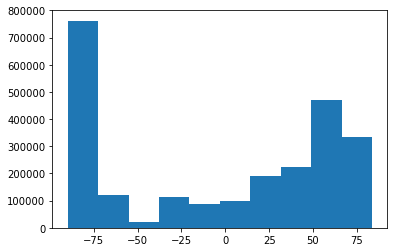

In [27]:
plt.hist(data[data['bana'].isnull()]['y'])

(array([   3119.,   26972.,   49427.,   90908.,   77564.,   87807.,
         113377.,  157792.,  124927.,   15527.]),
 array([-55.33333333, -42.68333333, -30.03333333, -17.38333333,
         -4.73333333,   7.91666667,  20.56666667,  33.21666667,
         45.86666667,  58.51666667,  71.16666667]),
 <a list of 10 Patch objects>)

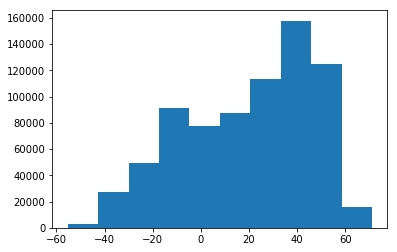

In [28]:
plt.hist(data[data['bana'].notnull()]['y'])

(array([  83503.,  200315.,  254722.,  261847.,  164247.,  321389.,
        300275.,  334446.,  344678.,  157372.]), array([ -1.80000000e+02,  -1.44008333e+02,  -1.08016667e+02,
        -7.20250000e+01,  -3.60333333e+01,  -4.16666650e-02,
         3.59500000e+01,   7.19416667e+01,   1.07933333e+02,
         1.43925000e+02,   1.79916667e+02]), <a list of 10 Patch objects>)
(array([    270.,   22453.,  102469.,   96888.,   34028.,  175221.,
        112625.,  105678.,   85860.,   11928.]), array([-179.16666667, -143.25833334, -107.35      ,  -71.44166667,
        -35.53333333,    0.375     ,   36.28333333,   72.19166667,
        108.1       ,  144.00833334,  179.91666667]), <a list of 10 Patch objects>)
(array([ 762163.,  119209.,   21593.,  112944.,   88782.,   99508.,
        192347.,  222521.,  468782.,  334945.]), array([-89.91666667, -72.55833334, -55.2       , -37.84166667,
       -20.48333333,  -3.125     ,  14.23333333,  31.59166667,
        48.95      ,  66.30833334,  83.66666667

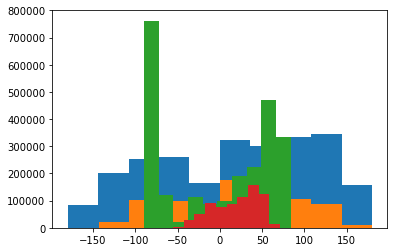

In [31]:
print(plt.hist(data[data['coco'].isnull()]['x']))
print(plt.hist(data[data['coco'].notnull()]['x']))
print(plt.hist(data[data['coco'].isnull()]['y']))
print(plt.hist(data[data['coco'].notnull()]['y']))

(array([  83503.,  200315.,  254722.,  261847.,  164247.,  321389.,
        300275.,  334446.,  344678.,  157372.]), array([ -1.80000000e+02,  -1.44008333e+02,  -1.08016667e+02,
        -7.20250000e+01,  -3.60333333e+01,  -4.16666650e-02,
         3.59500000e+01,   7.19416667e+01,   1.07933333e+02,
         1.43925000e+02,   1.79916667e+02]), <a list of 10 Patch objects>)
(array([    270.,   22453.,  102469.,   96888.,   34028.,  175221.,
        112625.,  105678.,   85860.,   11928.]), array([-179.16666667, -143.25833334, -107.35      ,  -71.44166667,
        -35.53333333,    0.375     ,   36.28333333,   72.19166667,
        108.1       ,  144.00833334,  179.91666667]), <a list of 10 Patch objects>)
(array([ 762163.,  119209.,   21593.,  112944.,   88782.,   99508.,
        192347.,  222521.,  468782.,  334945.]), array([-89.91666667, -72.55833334, -55.2       , -37.84166667,
       -20.48333333,  -3.125     ,  14.23333333,  31.59166667,
        48.95      ,  66.30833334,  83.66666667

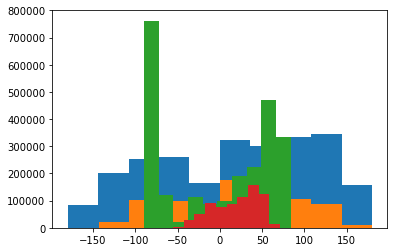

In [32]:
print(plt.hist(data[data['soyb'].isnull()]['x']))
print(plt.hist(data[data['soyb'].notnull()]['x']))
print(plt.hist(data[data['soyb'].isnull()]['y']))
print(plt.hist(data[data['soyb'].notnull()]['y']))

Data has been split between points that have crop data and those that don't.

## Model Training

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

In [62]:
X = data_no_nan.iloc[:,:21] #features of our data, that is, non-NaN
crops = {column : data_no_nan[column] for column in data_no_nan.columns[21:]}

In [49]:
#start of iteration

In [81]:
# Train on Lasso Model
# In the future we can train on multiple different models in parallel and get the best one.
models = {}
for crop in crops:
    Y = crops[crop]
    x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
    model = Lasso()
    lassoreg = Lasso.fit(model, x_train, y_train)
    models[crop] = model

/Users/emilioaureafuentes/anaconda2/envs/data-x/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [82]:
scores = {}
for crop in models:
    model = models[crop]
    scores[crop] = model.score(x_test, y_test)
for crop in scores:
    print ("{0} score: {1}".format(crop, str(scores[crop])))

acof score: -0.00442770969958
bana score: 0.000524650990796
barl score: -0.121963131832
bean score: -0.00333748915992
cass score: -0.141619924581
chic score: -0.00663292263359
cnut score: 0.0055162101898
coco score: -0.00135470675425
cott score: -0.00257855826717
cowp score: -0.00170166876884
grou score: 0.00697512618884
lent score: -0.00636723043491
maiz score: -2.02722055651
ocer score: -0.0235124210839
ofib score: -0.0058923701141
oilp score: -0.722184519626
ooil score: 0.00180849487585
opul score: -0.00365565467548
orts score: 0.021326445041
pige score: -0.00582719196703
plnt score: 0.00929259273915
pmil score: 0.000632093588641
pota score: -0.273100046229
rape score: -0.0121145003877
rcof score: -0.00409918668878
rest score: 0.00392200854784
rice score: -0.256280428508
sesa score: -0.00483462064797
smil score: -0.00450130486376
sorg score: 0.0100865774798
soyb score: -0.399944628567
sugb score: -0.356544271755
sugc score: -4.71492326661
sunf score: -0.00608047092843
swpo score: -0

In [111]:
# Here, we produce a dataframe that has the predictions for all crops for all locations
columns = ['x', 'y'] + [crop for crop in crops][:2]
df = pd.DataFrame([], columns=columns)

all_data_feature_vectors = []
x_values = []
y_values = []
for index, row in data.iterrows():
    feature_vector = row[:21]
    all_data_feature_vectors.append(feature_vector)
    x_values.append(feature_vector['x'])
    y_values.append(feature_vector['y'])

df['x'] = np.array(x_values)
df['y'] = np.array(y_values)

for crop in crops:
    crop_production = models[crop].predict(all_data_feature_vectors)
    df[crop] = np.array(crop_production)
    
df.head()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').